# Load QM7 dataset

In [ ]:
! wget http://quantum-machine.org/data/qm7.mat

--2023-07-07 07:28:35--  http://quantum-machine.org/data/qm7.mat
Resolving quantum-machine.org (quantum-machine.org)... 130.149.80.145
Connecting to quantum-machine.org (quantum-machine.org)|130.149.80.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17884280 (17M)
Saving to: ‘qm7.mat’

qm7.mat             100%[===================>]  17.06M  13.0MB/s    in 1.3s    

2023-07-07 07:28:37 (13.0 MB/s) - ‘qm7.mat’ saved [17884280/17884280]



In [ ]:
! pip install py3Dmol

In [ ]:
import py3Dmol

def view_molecule(data, index, style):

    bohr2ang = 0.529177249
    symbols = {1:'H', 6:'C', 7:'N', 8:'O', 16: 'S'}

    idx_nonzero = data['Z'][index].nonzero()
    Z = data['Z'][index][idx_nonzero]
    n_atoms = Z.size
    labels = np.vectorize(symbols.get)(Z)
    labels = labels.reshape(-1,1)

    coords = data['R'][index][0:n_atoms,:].reshape(-1,3) * bohr2ang

    xyz = np.concatenate((labels, coords), axis=1)
    n_atoms = xyz.shape[0]
    xyz_str = [str(i).strip('[]') for i in xyz]
    geom = str(n_atoms) + '\n' + ' ' + '\n'
    geom += '\n'.join(xyz_str)
    geom = geom.replace("'", "")

    for k in style.keys():
        assert k in ('line', 'stick', 'sphere', 'carton')

    molview = py3Dmol.view(width=350,height=350)
    molview.addModel(geom,'xyz')

    molview.setStyle(style)
    molview.setBackgroundColor('0xeeeeee')
    molview.zoomTo()

    return molview

In [ ]:
# Math libraries
import numpy as np

# Data handling and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [ ]:
import scipy.io

# The qm7 dataset will be load as a python dictionary
qm7_data = scipy.io.loadmat('qm7.mat')

In [ ]:
for k in qm7_data.keys():
    if "_" not in k:
        print("{} ---> {}".format(k,qm7_data[k].shape))
    else:
        print(k, qm7_data[k])

__header__ b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Feb 18 17:12:08 2013'
__version__ 1.0
__globals__ []
X ---> (7165, 23, 23)
R ---> (7165, 23, 3)
Z ---> (7165, 23)
T ---> (1, 7165)
P ---> (5, 1433)


The R and Z keys of the dictionary correspond to the Cartesian coordinates (given in Bohr) and the atomic charge of each atom in the molecules.

In [ ]:
print("Atomic charges:")
print(qm7_data['Z'][0])
print(" ")
print("Cartesian coordinates:")
print(qm7_data['R'][0])

Atomic charges:
[6. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 
Cartesian coordinates:
[[ 1.886438   -0.00464873 -0.00823921]
 [ 3.9499245  -0.00459203  0.00782347]
 [ 1.1976895   1.9404842   0.00782347]
 [ 1.1849339  -0.99726516  1.6593875 ]
 [ 1.2119948  -0.9589793  -1.710958  ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0. 

In [ ]:
nonzeros = np.count_nonzero(qm7_data['Z'],axis=1)
# Selec molecules with only 15 atoms
n_max_atoms = 15
idx = np.where(nonzeros == n_max_atoms)
qm7_data['X'] = qm7_data['X'][idx][:,:n_max_atoms,:n_max_atoms]
qm7_data['R'] = qm7_data['R'][idx][:,:n_max_atoms]
qm7_data['Z'] = qm7_data['Z'][idx][:,:n_max_atoms]
qm7_data['T'] = qm7_data['T'].flatten()[idx]

## Building the Coulomb matrix dataset for the analysis

In [ ]:
print("Coulomb matrix:")
print(qm7_data['X'][0])

Coulomb matrix:
[[73.51669    17.79188    10.574583   10.609484    6.72828     4.352822
   2.0783362   1.5839126   1.6360577   1.5685378   1.2611265   1.013529
   1.6256311   1.0404118   0.9301662 ]
 [17.79188    36.858105   12.444374   12.511555    7.4616017   1.6210611
   2.899028    1.4651774   1.4753506   1.4622504   1.4564468   1.1054873
   1.4680866   1.1392418   0.90926206]
 [10.574583   12.444374   36.858105    7.4560533  12.53489     1.2365621
   1.4679073   2.8932884   2.892906    1.1357094   1.1043904   1.4606544
   0.9081943   1.4643822   1.4723637 ]
 [10.609484   12.511555    7.4560533  36.858105    6.0957327   1.2397863
   1.4769639   1.133233    0.9116201   2.897561    2.9032035   1.1057171
   2.8976808   0.9178894   0.76837534]
 [ 6.72828     7.4616017  12.53489     6.0957327  36.858105    0.7923406
   1.13689     1.4751805   1.4800829   0.914806    1.1048201   2.9026
   0.76742256  2.9010375   2.900114  ]
 [ 4.352822    1.6210611   1.2365621   1.2397863   0.7923406   0

In [ ]:
n_samples, cm_rows, cm_cols = qm7_data['X'].shape
# Transform the original tensor shape of the CM descriptor, qm7['X'], into a 2D matrix
qm7_cm = qm7_data['X'].reshape(-1, cm_rows * cm_cols)
qm7_cm.shape

(1219, 225)

In [ ]:
df_qm7_cm = pd.DataFrame(qm7_cm)
df_qm7_cm.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
1008,73.516693,13.128277,6.898043,20.752920,10.661843,8.928872,7.211328,1.471083,1.552068,1.337539,...,1.564040,0.806622,0.230708,0.221972,0.093108,0.105429,0.326204,0.082709,0.145719,0.5
111,73.516693,10.570868,10.612719,17.843496,7.552197,6.712225,4.324624,2.060807,2.065679,1.139416,...,2.929591,0.119086,0.136440,0.140887,0.205491,0.180530,0.170483,0.209901,0.291684,0.5
17,53.358707,15.155648,8.676389,15.301150,6.049547,5.608386,1.718589,1.344897,1.716885,0.961988,...,2.928110,0.142680,0.214249,0.107565,0.170560,0.098162,0.290691,0.095627,0.209945,0.5
282,73.516693,14.253613,17.760670,17.737139,10.870183,10.125866,10.115960,2.062721,1.513806,1.572131,...,0.725168,0.709412,0.217867,0.296037,0.104507,0.116219,0.112345,0.101677,0.193241,0.5
197,53.358707,5.429434,9.029895,16.156294,6.015698,7.246587,15.343001,3.643919,1.810319,1.367942,...,0.632423,2.902313,0.227708,0.145475,0.120302,0.093204,0.091723,0.298651,0.298117,0.5


# Principal Component Analysis (PCA)

In [ ]:
from sklearn.decomposition import PCA

## Without data standardization

In [ ]:
pca = PCA(n_components=2)
pca.fit(df_qm7_cm)

PCA(n_components=2)

In [ ]:
X_reduced = pca.transform(df_qm7_cm)
X_reduced

array([[ -5.5403666,  45.32131  ],
       [ -4.9075527,  45.959316 ],
       [ -4.5656095,  45.632    ],
       ...,
       [-40.219536 ,   7.565469 ],
       [-39.983734 ,   7.7647185],
       [-40.00479  ,   8.081244 ]], dtype=float32)

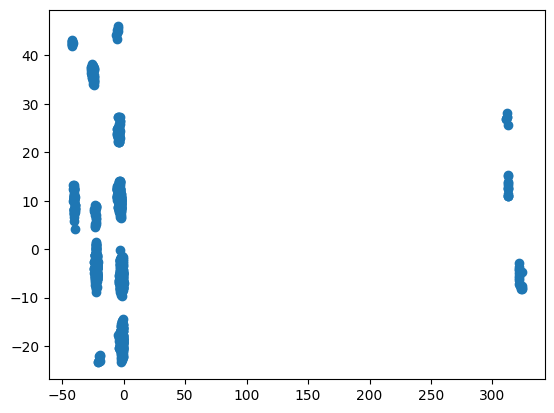

In [ ]:
plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.show()

## With data standardization

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

In [ ]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(qm7_cm))
df_scaled

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,-0.044549,0.722757,-0.483804,-0.465096,-1.047523,-1.275253,-1.402952,-0.467348,-0.102323,-0.025052,...,-1.369330,-2.136465,1.770912,1.724548,-0.346133,-0.170830,1.859144,-0.852049,0.988651,0.0
1,-0.044549,0.725228,-0.476380,0.906262,-1.037807,-1.803589,-1.410930,-0.434049,-0.137355,0.747407,...,-1.334562,-2.136684,1.809340,1.639142,-0.993904,-0.878766,1.846415,1.199059,-1.290658,0.0
2,-0.044549,0.728975,0.744357,-0.458203,-0.183195,-1.803703,-1.411218,0.059881,0.532819,0.029254,...,-1.242912,-2.067548,-0.727372,-0.649023,-0.956618,2.237051,-0.773411,1.185188,-1.295472,0.0
3,-0.044549,0.718454,-0.508503,0.906193,-0.171030,-1.805138,-1.523623,-0.526795,0.517558,0.034193,...,-1.323124,-2.150048,-0.077073,3.578688,-0.494582,2.250263,-0.400732,-0.825875,-1.096336,0.0
4,-0.723964,0.098569,-0.128764,-0.079294,-0.871444,-1.926379,-1.556895,-0.584487,-0.342716,-0.789746,...,-1.223060,-2.135624,-0.818050,-0.728077,2.983373,2.272133,-0.452575,-0.873451,-1.081588,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,-0.418149,0.950632,0.624795,-0.689563,-0.426326,-0.183215,-0.412029,-0.852373,-0.831957,0.463348,...,0.419067,0.556566,-0.442788,-0.179744,-1.095523,-0.843277,0.821287,-1.042932,0.856048,0.0
1215,-0.418149,0.785287,0.626409,-0.664681,-0.305158,-0.210053,-0.270636,-0.890492,-0.761952,-0.728877,...,0.369628,0.535037,-0.336154,-0.653435,1.322095,0.983624,1.844822,1.194901,-1.267976,0.0
1216,-0.723964,-0.125038,-0.934655,0.006048,-0.689139,-0.593179,1.620175,-0.630176,-0.899804,-1.011699,...,-0.623292,0.559996,-0.193912,-0.538604,-0.795345,0.766032,-0.541173,-0.910498,0.847176,0.0
1217,-0.723964,-0.086327,-0.047584,-0.942256,-0.678343,0.985074,-0.047409,-1.102956,-1.064490,-0.284456,...,-0.542386,0.559233,0.961996,0.978596,-0.849560,-0.206499,1.688425,-0.832395,-1.078552,0.0


In [ ]:
pca = PCA(n_components=2)
pca.fit(df_scaled)

PCA(n_components=2)

In [ ]:
X_reduced = pca.transform(df_scaled)
X_reduced

array([[11.536731  , -4.4937553 ],
       [10.823525  , -4.3910446 ],
       [11.393025  , -3.8252816 ],
       ...,
       [-0.3270474 , -0.13287006],
       [-0.14470665, -3.0900407 ],
       [-0.5771954 , -3.3223352 ]], dtype=float32)

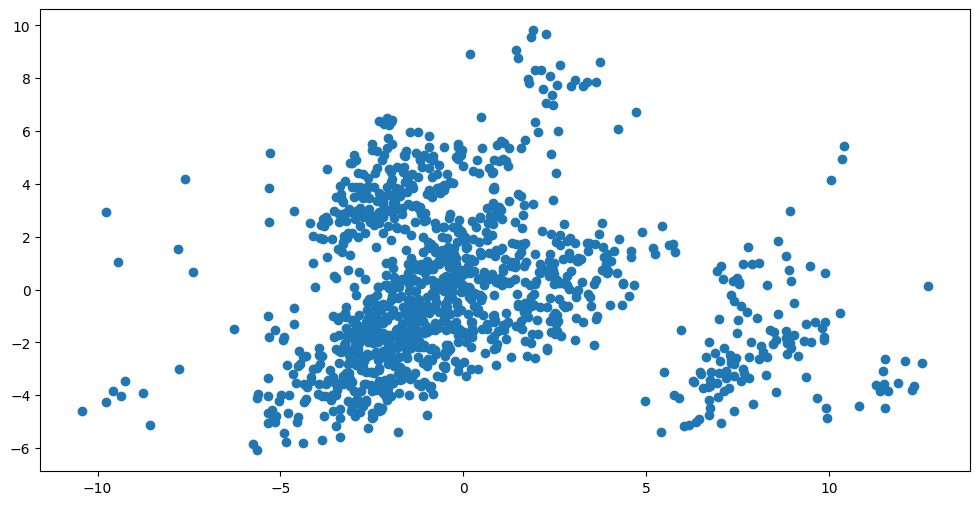

In [ ]:
plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.show()

# Selecting number of principal components

Choosing the correct number of PC is vital to successfully reducing the dimensionality of your data. If the number of principle components is set to low not all of the variance in the data is accounted for, while too many principle components can be redundant. In order to evaluate how many PCs to choose the explained variance ratio for each principle component can be calculated and visualized. In the following section, PCA is performed for 5 PCs and visualized.

- Mentions sensible threshold for explained variance

[0.06134313 0.04071221 0.03209468 0.03092541 0.02384255 0.02285947
 0.02065166 0.01955219]


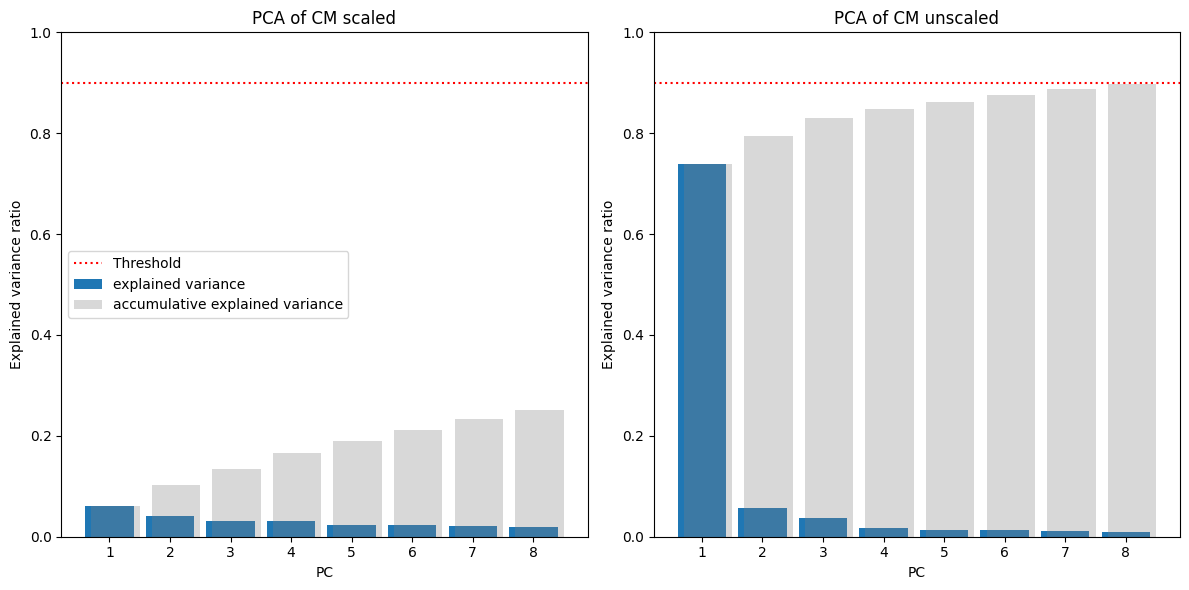

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.subplot(1, 2, 1)
pca_scaled = PCA(n_components=8)
pca_scaled.fit(df_scaled)
X_new_scaled = pca_scaled.transform(df_scaled)
pcs_scaled = np.arange(len(pca_scaled.explained_variance_ratio_))+1
print (pca_scaled.explained_variance_ratio_)
s = 0
cumsum = [(s:=s+i) for i in pca_scaled.explained_variance_ratio_]
plt.bar(pcs_scaled, pca_scaled.explained_variance_ratio_,label="explained variance")
plt.bar(pcs_scaled+0.1, cumsum, color="gray", alpha = 0.3,label="accumulative explained variance")
plt.title("PCA of CM scaled")
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.ylim(0,1)
plt.axhline(y = 0.9, color = 'r', linestyle = ':',label="Threshold")
plt.legend(loc="center left")

plt.subplot(1, 2, 2)
pca = PCA(n_components=8)
pca.fit(df_qm7_cm)
X_new = pca.transform(df_qm7_cm)
pcs = np.arange(len(pca.explained_variance_ratio_))+1
s = 0
cumsum = [(s:=s+i) for i in pca.explained_variance_ratio_]
plt.bar(pcs, pca.explained_variance_ratio_,label="explained variance")
plt.bar(pcs+0.1, cumsum, color="gray", alpha = 0.3,label="accumulative explained variance")
plt.title("PCA of CM unscaled")
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.ylim(0,1)
#plt.legend(loc="center left")
plt.axhline(y = 0.9, color = 'r', linestyle = ':')


plt.tight_layout()


# Comparison of scaled vs. unscaled Coulomb matrix for PCA
As can be seen above the explained variance for the 8 first principle components is lower for the scaled Coulomb matrix than for the unscaled one. Althogh on the first glance the results from the PCA of the unscaled Coulomb matrix look more promising i.e. more variance explained with fewer principle components. Sadly this is missleading in the example.
    -> Take a closer look at the coulomb matrix and think about why normalization might be needed an why an unormalized Coulomb matrix leads to a seemingly "better PCA".


# Interpreting principal components

In [ ]:
pca = PCA(n_components=2)
pca.fit(df_scaled)
X_reduced = pca.transform(df_scaled)

In [ ]:
df_importance = pd.DataFrame(pca.components_)
df_importance = df_importance.apply(np.abs)
df_importance = df_importance.transpose()
df_importance.columns = ["PC1", "PC2"]
df_importance.head(5)

,PC1,PC2
0,0.983097,0.067181
1,0.062082,0.062623
2,0.062182,0.047096
3,0.055173,0.029547
4,0.033363,0.038193


In [ ]:
df_importance["PC1"].sort_values(ascending=False)

0      0.983097
32     0.063255
30     0.062182
2      0.062182
15     0.062082
         ...   
176    0.000000
160    0.000000
144    0.000000
128    0.000000
224    0.000000
Name: PC1, Length: 225, dtype: float32

In [ ]:
X_new[:,0].max()
df_X_new = pd.DataFrame(X_new)
df_X_new_filtered = df_X_new.loc[df_X_new[0] > 250]

test = pd.DataFrame(qm7_data['Z'][list(df_X_new_filtered.index.values)])
print(test)
# SUM of heavy atoms exluding hydrogens
#plt.hist(test)

      0     1     2     3     4     5     6    7    8    9    10   11   12  \
0    6.0   6.0   6.0   6.0   6.0   6.0  16.0  1.0  1.0  1.0  1.0  1.0  1.0   
1    6.0   6.0   6.0   6.0  16.0   8.0   8.0  1.0  1.0  1.0  1.0  1.0  1.0   
2    6.0   6.0   6.0   6.0   6.0   6.0  16.0  1.0  1.0  1.0  1.0  1.0  1.0   
3    6.0   6.0   6.0   7.0   6.0   7.0  16.0  1.0  1.0  1.0  1.0  1.0  1.0   
4    6.0   6.0   6.0   7.0   6.0  16.0   7.0  1.0  1.0  1.0  1.0  1.0  1.0   
5    6.0   6.0   6.0  16.0   6.0   6.0   6.0  1.0  1.0  1.0  1.0  1.0  1.0   
6    6.0   6.0   6.0   6.0   6.0   6.0  16.0  1.0  1.0  1.0  1.0  1.0  1.0   
7    6.0   6.0   6.0  16.0   8.0   8.0   6.0  1.0  1.0  1.0  1.0  1.0  1.0   
8    6.0   6.0   6.0   6.0   6.0   6.0  16.0  1.0  1.0  1.0  1.0  1.0  1.0   
9    6.0   6.0   6.0   6.0  16.0   6.0   6.0  1.0  1.0  1.0  1.0  1.0  1.0   
10   6.0   6.0   6.0   7.0   6.0   7.0  16.0  1.0  1.0  1.0  1.0  1.0  1.0   
11   6.0   6.0   6.0   7.0   6.0   7.0  16.0  1.0  1.0  1.0  1.0

## Visualizing the molecular structures

In [ ]:
df_pca_cm = pd.DataFrame(X_reduced)
idx_largest_pc1 = df_pca_cm[df_pca_cm[0] > 250].index.tolist()
idx_smallest_pc1 = df_pca_cm[df_pca_cm[0] < 50].index.tolist()

In [ ]:
s = {'stick': {'radius': .15}, 'sphere': {'scale': 0.20}}
mol = view_molecule(qm7_data, idx_largest_pc1[5], s)
mol

In [ ]:
mol = view_molecule(qm7_data, idx_smallest_pc1[20], s)
mol